In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from os.path import join
import os
import random
from functools import partial
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, concatenate
from keras.optimizers import Nadam
from keras.layers.advanced_activations import ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.backend import binary_crossentropy
import tensorflow as tf

K.set_image_data_format('channels_last')

print(K.image_data_format())
smooth = 1e-12
num_examples = 0

channels_last


In [2]:
import glob
import ntpath
image_size = 512
def load_files():
    global image_size
    global num_examples
    mask_images=[]
    ori_images = []
    
    #training masks
    overlay_path = "train/overlay/*"
    overlay = glob.glob(overlay_path)
    mask_path = "train/masks1/"
    mask_set1 = "unet_train/gt/*"
    ogmask = glob.glob(mask_set1)
    print("Loading masks")
    for fl in overlay:
        basenm = ntpath.basename(fl)
        nm_output_mask = mask_path+basenm
        train_image = cv2.imread(nm_output_mask,0)
        retval, train_image = cv2.threshold(train_image, 150, 1, cv2.THRESH_BINARY)
        train_image = cv2.resize(train_image, (image_size, image_size))
        train_image = np.expand_dims(train_image, axis=2)
        mask_images.append(train_image)
    for fl in ogmask:
        train_image = cv2.imread(fl,0)
        shape = train_image.shape
        #Supervisely gives 3 images in out and we need the mask only
        start = shape[1]//3
        start = start * 2
        end = shape[1]
        train_image = train_image[: , start:end]
        retval, train_image = cv2.threshold(train_image, 150, 1, cv2.THRESH_BINARY)
        train_image = cv2.resize(train_image, (image_size, image_size))
        train_image = np.expand_dims(train_image, axis=2)
        mask_images.append(train_image)
        
    #original images
    orig_path = "train/btrain/"
    og_set1 = "unet_train/orig/*"
    og = glob.glob(og_set1)
    print("loading original")
    for fl in overlay:
        basenm = ntpath.basename(fl)
        nm_output_og = orig_path+basenm
        orig_images = cv2.imread(nm_output_og)
        orig_images = cv2.resize(orig_images, (image_size, image_size))
        ori_images.append(orig_images)
    for fl in og:
        orig_images = cv2.imread(fl)
        orig_images = cv2.resize(orig_images, (image_size, image_size))
        ori_images.append(orig_images)
        
    masked = np.array(mask_images)
    origi = np.array(ori_images)
    num_examples = masked.shape[0]
    return masked, origi

masks, origi = load_files()

Loading masks
loading original


In [2]:
import glob
image_size = 512
def load_files():
    global image_size
    global num_examples
    mask_images=[]
    ori_images = []

    mask_path = "unet_train/gt/*"
    masks = glob.glob(mask_path)
    print("Loading masks")
    for fl in masks:
        train_image = cv2.imread(fl, cv2.IMREAD_GRAYSCALE)
        shape = train_image.shape
        #Supervisely gives 3 images in out and we need the mask only
        start = shape[1]//3
        start = start * 2
        end = shape[1]
        train_image = train_image[: , start:end]
        train_image = cv2.resize(train_image, (image_size, image_size))
        mask_images.append(train_image)
    orig_path = "unet_train/orig/*"
    orig = glob.glob(orig_path)
    print("loading original")
    for fl in orig:
        orig_images = cv2.imread(fl)
        orig_images = cv2.resize(orig_images, (image_size, image_size))
        ori_images.append(orig_images)
    masked = np.array(mask_images)
    origi = np.array(ori_images)
    num_examples = masked.shape[0]
    return masked, origi

masks, origi = load_files()


Loading masks
loading original


In [3]:

masks.shape

(12033, 512, 512, 1)

In [3]:
'''
Capsules for Object Segmentation (SegCaps)
Original Paper by Rodney LaLonde and Ulas Bagci (https://arxiv.org/abs/1804.04241)
Code written by: Rodney LaLonde
If you use significant portions of this code or the ideas from our paper, please cite it :)
If you have any questions, please email me at lalonde@knights.ucf.edu.

This file contains the network definitions for the various capsule network architectures.
'''

from keras import layers, models
from keras.utils import print_summary

from capsule_layers import ConvCapsuleLayer, DeconvCapsuleLayer, Mask, Length

def capsnet(input_shape=(512, 512, 3),
                 n_class=1):
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu', name='conv1')(x)

    # Reshape layer to be 1 capsule x [filters] atoms
    _, H, W, C = conv1.get_shape()
    conv1_reshaped = layers.Reshape((H.value, W.value, 1, C.value))(conv1)

    # Layer 1: Primary Capsule: Conv cap with routing 1
    primary_caps = ConvCapsuleLayer(kernel_size=5, num_capsule=2, num_atoms=16, strides=2, padding='same',
                                    routings=1, name='primarycaps')(conv1_reshaped)

    # Layer 2: Convolutional Capsule
    conv_cap_2_1 = ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=16, strides=1, padding='same',
                                    routings=3, name='conv_cap_2_1')(primary_caps)

    # Layer 2: Convolutional Capsule
    conv_cap_2_2 = ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=32, strides=2, padding='same',
                                    routings=3, name='conv_cap_2_2')(conv_cap_2_1)

    # Layer 3: Convolutional Capsule
    conv_cap_3_1 = ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=1, padding='same',
                                    routings=3, name='conv_cap_3_1')(conv_cap_2_2)

    # Layer 3: Convolutional Capsule
    conv_cap_3_2 = ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=64, strides=2, padding='same',
                                    routings=3, name='conv_cap_3_2')(conv_cap_3_1)

    # Layer 4: Convolutional Capsule
    conv_cap_4_1 = ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=1, padding='same',
                                    routings=3, name='conv_cap_4_1')(conv_cap_3_2)

    # Layer 1 Up: Deconvolutional Capsule
    deconv_cap_1_1 = DeconvCapsuleLayer(kernel_size=4, num_capsule=8, num_atoms=32, upsamp_type='deconv',
                                        scaling=2, padding='same', routings=3,
                                        name='deconv_cap_1_1')(conv_cap_4_1)

    # Skip connection
    up_1 = layers.Concatenate(axis=-2, name='up_1')([deconv_cap_1_1, conv_cap_3_1])

    # Layer 1 Up: Deconvolutional Capsule
    deconv_cap_1_2 = ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=32, strides=1,
                                      padding='same', routings=3, name='deconv_cap_1_2')(up_1)

    # Layer 2 Up: Deconvolutional Capsule
    deconv_cap_2_1 = DeconvCapsuleLayer(kernel_size=4, num_capsule=4, num_atoms=16, upsamp_type='deconv',
                                        scaling=2, padding='same', routings=3,
                                        name='deconv_cap_2_1')(deconv_cap_1_2)

    # Skip connection
    up_2 = layers.Concatenate(axis=-2, name='up_2')([deconv_cap_2_1, conv_cap_2_1])

    # Layer 2 Up: Deconvolutional Capsule
    deconv_cap_2_2 = ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=16, strides=1,
                                      padding='same', routings=3, name='deconv_cap_2_2')(up_2)

    # Layer 3 Up: Deconvolutional Capsule
    deconv_cap_3_1 = DeconvCapsuleLayer(kernel_size=4, num_capsule=2, num_atoms=16, upsamp_type='deconv',
                                        scaling=2, padding='same', routings=3,
                                        name='deconv_cap_3_1')(deconv_cap_2_2)

    # Skip connection
    up_3 = layers.Concatenate(axis=-2, name='up_3')([deconv_cap_3_1, conv1_reshaped])

    # Layer 4: Convolutional Capsule: 1x1
    seg_caps = ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=16, strides=1, padding='same',
                                routings=3, name='seg_caps')(up_3)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    out_seg = Length(num_classes=n_class, seg=True, name='out_seg')(seg_caps)


    # Models for training and evaluation (prediction)
    model = models.Model(inputs=x, outputs=[out_seg])
    
    
    return model

In [5]:
wmodel = capsnet()
print_summary(model=wmodel, positions=[.38, .65, .75, 1.])




__________________________________________________________________________________________________
Layer (type)                         Output Shape              Param #   Connected to             
input_1 (InputLayer)                 (None, 512, 512, 3)       0                                  
__________________________________________________________________________________________________
conv1 (Conv2D)                       (None, 512, 512, 16)      1216      input_1[0][0]            
__________________________________________________________________________________________________
reshape_1 (Reshape)                  (None, 512, 512, 1, 16)   0         conv1[0][0]              
__________________________________________________________________________________________________
primarycaps (ConvCapsuleLayer)       (None, 256, 256, 2, 16)   12832     reshape_1[0][0]          
__________________________________________________________________________________________________
conv_cap_2

In [4]:
from os.path import join
import numpy as np

from keras.optimizers import Adam
from keras.utils.training_utils import multi_gpu_model
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau, TensorBoard

from custom_losses import dice_hard

opt = Adam(lr=0.0001, beta_1=0.99, beta_2=0.999, decay=1e-6)

metrics = {'out_seg': dice_hard}



In [5]:
from keras.losses import binary_crossentropy


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def jaccard_coef(y_true, y_pred, smooth=0.0):
    '''Average jaccard coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred)
    return loss

def unet_loss(y_true, y_pred):
    loss = bce_dice_loss(y_true,y_pred) - K.log(jaccard_coef(y_true,y_pred))
    return loss

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard,RemoteMonitor
from sklearn.model_selection import train_test_split

t_ori, v_ori , t_masks, v_masks = train_test_split(origi, masks, test_size=0.33, random_state=42)

In [9]:
print(t_ori.shape)
print(v_ori.shape)
print(t_masks.shape)
print(v_masks.shape)




(8062, 512, 512, 3)
(3971, 512, 512, 3)
(8062, 512, 512, 1)
(3971, 512, 512, 1)


In [10]:
t_ori = t_ori[:32,:,:,:]
v_ori = v_ori[:16,:,:,:]
t_masks = t_masks[:32,:,:,:]
v_masks = v_masks[:16,:,:,:]

In [10]:
class VBatchGenerator:
    
    def __init__(self, size, n_cls, batch_size):
        self.size = size
        self.n_cls = n_cls
        self.batch_size = batch_size
        self.i = 0
    
    def get_batch(self):
        global v_masks
        global v_ori
        while True:
            origbatch = np.zeros((self.batch_size, self.size, self.size, 3))
            gtbatch = np.zeros((self.batch_size, self.size, self.size, 1))
            perm = np.arange(num_val)
            np.random.shuffle(perm)
            somev_masks = [v_masks[j] for j in perm]
            somev_ori = [v_ori[j] for j in perm]
            for i in range(self.batch_size):
                origbatch[i] = somev_ori[i]
                gtbatch[i] = somev_masks[i]
            yield origbatch, gtbatch

In [11]:
class BatchGenerator:
    
    def __init__(self, size, n_cls, batch_size):
        self.size = size
        self.n_cls = n_cls
        self.batch_size = batch_size
        self.i = 0
    
    def get_batch(self):
        global t_ori
        global t_masks
        while True:
            orig_btch = np.zeros((self.batch_size, self.size, self.size, 3))
            gt_btch = np.zeros((self.batch_size, self.size, self.size, 1))
            perm = np.arange(num_examples)
            np.random.shuffle(perm)
            some_masks = [t_masks[j] for j in perm]
            some_ori = [t_ori[j] for j in perm]
            for i in range(self.batch_size):
                orig_btch[i] = some_ori[i]
                gt_btch[i] = some_masks[i]
            yield orig_btch, gt_btch

In [12]:
recon_wei= 131.072

loss = {'out_seg': 'binary_crossentropy'}
loss_weighting = {'out_seg': 1.}
metrics = {'out_seg': dice_hard}
from time import time
num_examples = t_ori.shape[0]
num_val = v_ori.shape[0]
batch_size = 8

s_tr =np.floor(float(t_ori.shape[0]) / float(batch_size))
s_val =np.floor(float(v_ori.shape[0]) / float(batch_size))
train_batch_generator = BatchGenerator( image_size, 1, batch_size)
valid_batch_generator = VBatchGenerator(image_size, 1,batch_size)

with tf.device("/cpu:0"):
    wmodel.compile(optimizer=opt, loss=loss, loss_weights=loss_weighting, metrics=metrics)
    model = multi_gpu_model(wmodel, gpus=8)
    model.__setattr__('callback_model', wmodel)
model.compile(optimizer=opt, loss=loss, loss_weights=loss_weighting, metrics=metrics)

In [16]:
recon_wei= 131.072

loss = {'out_seg': 'binary_crossentropy'}
loss_weighting = {'out_seg': 1.}
metrics = {'out_seg': dice_hard}
from time import time
num_examples = t_ori.shape[0]
num_val = v_ori.shape[0]
batch_size = 1

s_tr =np.floor(float(t_ori.shape[0]) / float(batch_size))
s_val =np.floor(float(v_ori.shape[0]) / float(batch_size))
train_batch_generator = BatchGenerator( image_size, 1, batch_size)
valid_batch_generator = VBatchGenerator(image_size, 1,batch_size)


wmodel.compile(optimizer=opt, loss=loss, loss_weights=loss_weighting, metrics=metrics)


In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

In [14]:
tensorboard = TensorBoard(log_dir="segcaps/", batch_size=8,write_graph=True)
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             RemoteMonitor(root='http://localhost:9000', path='/publish/epoch/end/', field='data', headers=None),
             tensorboard]

model.fit_generator(train_batch_generator.get_batch(),max_queue_size=40, use_multiprocessing=False,
                    steps_per_epoch=s_tr,epochs=20, callbacks=callbacks, validation_data=valid_batch_generator.get_batch(),validation_steps=s_val,verbose=1)

Epoch 1/20
1007/1007 [==============================] - 4322s 4s/step - loss: 0.8235 - dice_hard: 0.6899 - val_loss: 0.3612 - val_dice_hard: 0.8325


/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:588: UserWarning: Warning: could not reach RemoteMonitor root server at http://localhost:9000
  'root server at ' + str(self.root))


Epoch 2/20
1007/1007 [==============================] - 4295s 4s/step - loss: 0.2755 - dice_hard: 0.8790 - val_loss: 0.2217 - val_dice_hard: 0.9065
Epoch 3/20
1007/1007 [==============================] - 4305s 4s/step - loss: 0.1713 - dice_hard: 0.9275 - val_loss: 0.1413 - val_dice_hard: 0.9390
Epoch 4/20
1007/1007 [==============================] - 4306s 4s/step - loss: 0.1161 - dice_hard: 0.9458 - val_loss: 0.0867 - val_dice_hard: 0.9574
Epoch 5/20
1007/1007 [==============================] - 4314s 4s/step - loss: 0.0742 - dice_hard: 0.9616 - val_loss: 0.0517 - val_dice_hard: 0.9752
Epoch 6/20
1007/1007 [==============================] - 4310s 4s/step - loss: 0.0571 - dice_hard: 0.9696 - val_loss: 0.0441 - val_dice_hard: 0.9768
Epoch 7/20
1007/1007 [==============================] - 4312s 4s/step - loss: 0.0420 - dice_hard: 0.9771 - val_loss: 0.0346 - val_dice_hard: 0.9824
Epoch 8/20
1007/1007 [==============================] - 4314s 4s/step - loss: 0.0372 - dice_hard: 0.9800 - val_l

In [16]:
from importlib import reload
reload(K)
import h5py
model1 = model.get_layer('model_1')

model1.save('segcaps_final.h5')

Using TensorFlow backend.


In [22]:
import keras
print(k.__version__)

NameError: name 'k' is not defined

In [67]:
train_batch_generator = BatchGenerator( image_size, 1, 4)

a,b= train_batch_generator.get_batch()

IndexError: list index out of range

In [1]:
orig_images= cv2.imread("/home/ubuntu/research/train/btrain/4117.png")
orig_images = cv2.resize(orig_images, (512, 512))
image = np.expand_dims(orig_images, axis=0)
mpo = mo.predict(image)

NameError: name 'cv2' is not defined

In [8]:
mpo.shape

(1, 512, 512, 1)

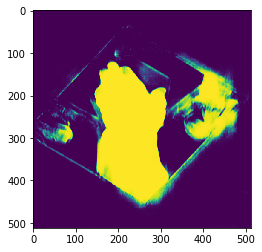

In [9]:
plt.imshow(np.resize(mpo,(512,512)))

In [6]:
from keras.models import load_model
from custom_losses import dice_hard
mo = load_model('segcaps_final.h5',custom_objects={'ConvCapsuleLayer':ConvCapsuleLayer,'DeconvCapsuleLayer':DeconvCapsuleLayer,'Length':Length,'Mask':Mask,'dice_hard':dice_hard})